In [1]:
from matplotlib import pyplot as plt
from windrose import WindroseAxes
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from utils.data import get_data
import os, numpy as np, seaborn as sns, pandas as pd

In [2]:
data = get_data()

In [32]:
data[data.stod == 4275].iloc[:10]

,time,stod,f,fg,d,X,Y,ws_15,ws_150,ws_250,...,130,131,132,133,134,135,136,137,138,139
26821,2005-09-13 18:00:00,4275,20.52,23.86,20.8,721568.2334,533229.2891,16.2948,19.1481,19.8991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26822,2005-09-23 09:00:00,4275,20.52,23.80,15.0,721568.2334,533229.2891,10.3852,11.1627,11.2241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26823,2005-09-26 15:00:00,4275,21.30,25.87,79.8,721568.2334,533229.2891,11.2164,12.1531,12.3254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26824,2005-09-28 15:00:00,4275,20.24,23.58,307.9,721568.2334,533229.2891,16.7972,19.4662,20.0711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26825,2005-10-01 00:00:00,4275,30.98,36.06,5.0,721568.2334,533229.2891,17.6400,20.7566,21.6213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26826,2005-10-02 18:00:00,4275,21.60,27.79,253.3,721568.2334,533229.2891,5.5781,7.6557,8.3525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26827,2005-10-29 12:00:00,4275,26.95,35.01,278.9,721568.2334,533229.2891,10.5514,11.8930,10.9015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26828,2005-10-30 21:00:00,4275,20.77,22.87,76.1,721568.2334,533229.2891,14.5169,16.6658,17.0136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26829,2005-11-12 00:00:00,4275,21.65,25.28,358.6,721568.2334,533229.2891,15.2408,17.1991,17.4300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26830,2005-11-13 15:00:00,4275,25.34,30.14,261.5,721568.2334,533229.2891,7.0414,10.7174,12.3411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def plotAllScatterFVFg(dirpath = './data/parts/'):
    files = [dirpath + file for file in os.listdir(dirpath) if file.endswith('.feather')]

    for file in files:
        data = pd.read_feather(file)
        data = data[data.f < data.fg]
        data = data[data.fg <= 75]
        plt.scatter(data.f, data.fg, s = 0.1, c = 'grey', marker = 'x')

    plt.xlabel('f')
    plt.ylabel('fg')
    plt.show()

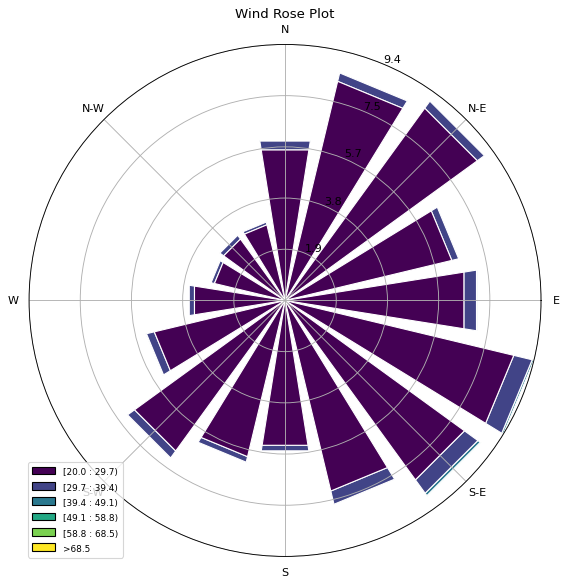

In [9]:
# Plot wind rose
ax = WindroseAxes.from_ax()
ax.bar(data.d, data.f, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose Plot')
plt.show()

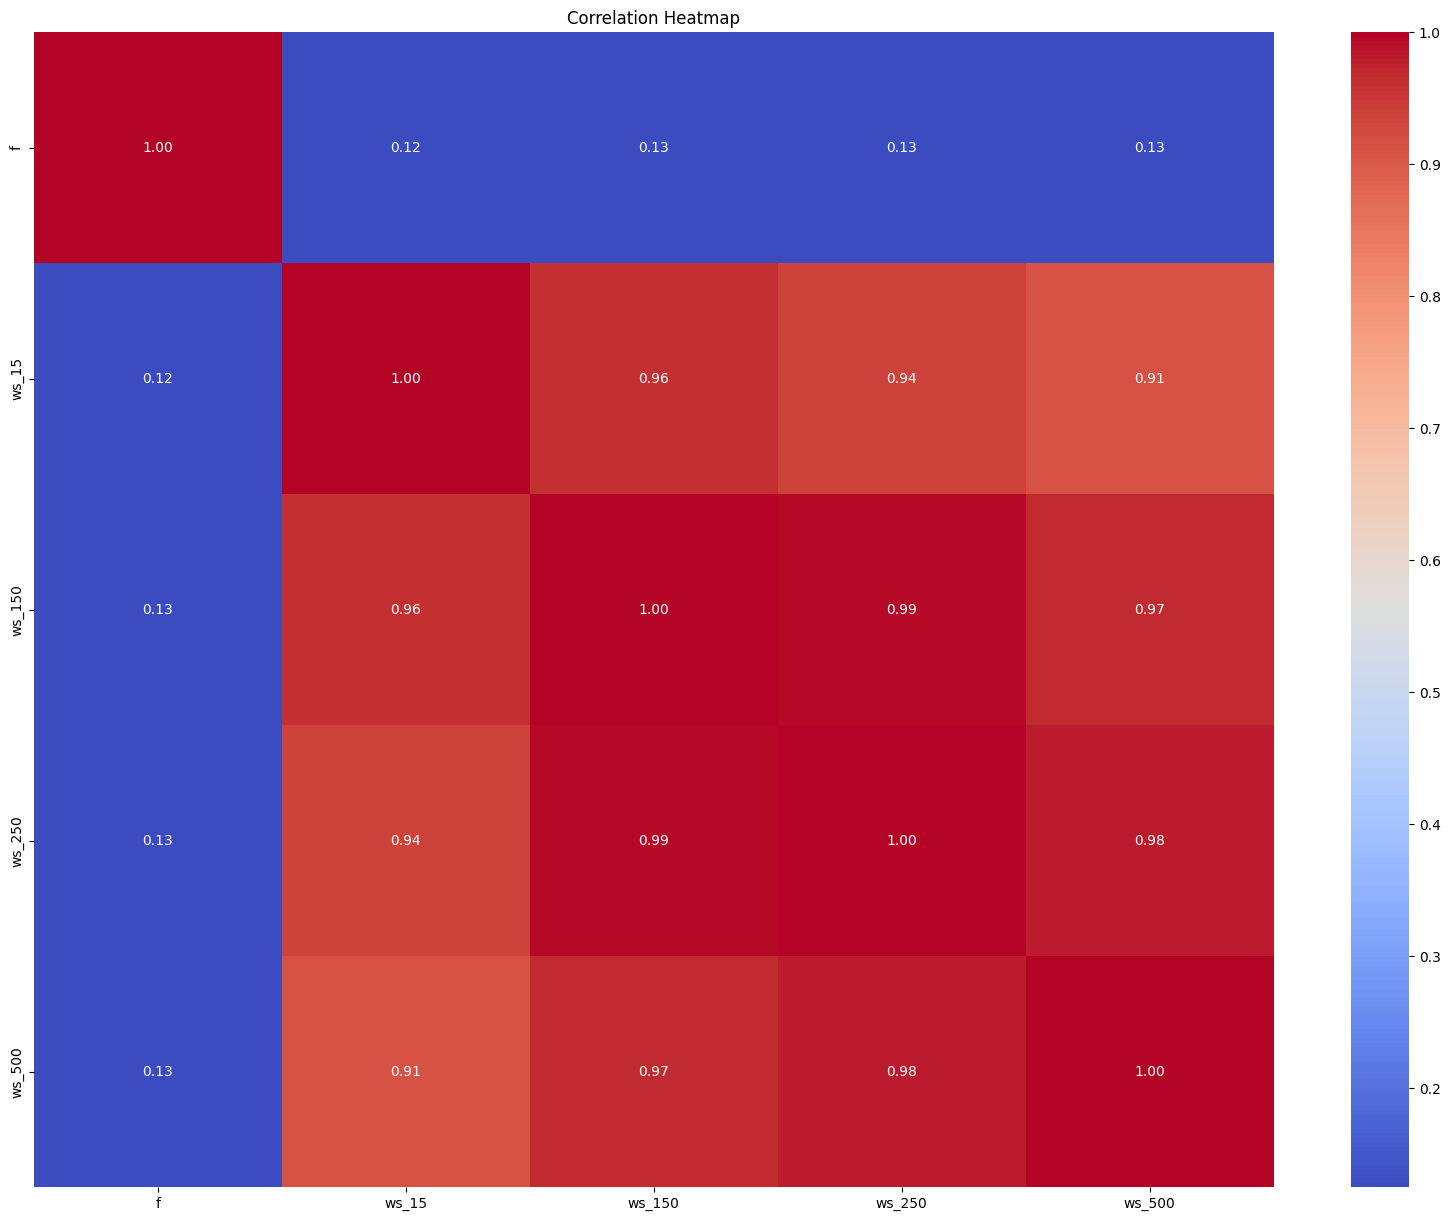

In [10]:
import seaborn as sns
correlation_matrix = data[['f', 'ws_15', 'ws_150', 'ws_250', 'ws_500']].corr()
# Plot correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

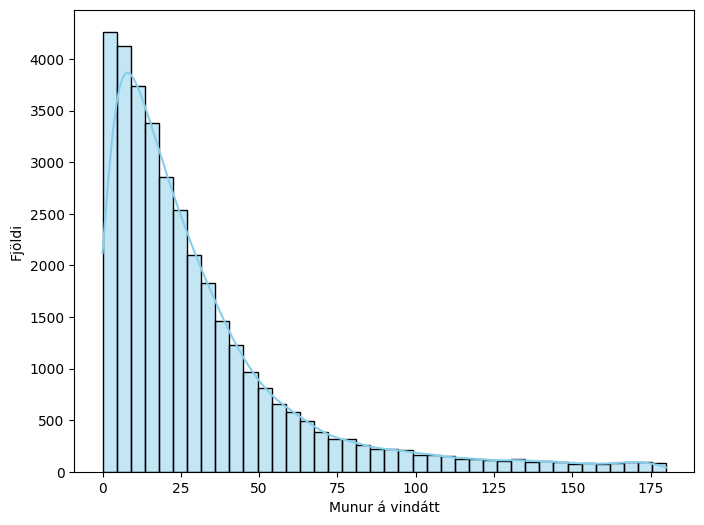

In [12]:
# Calculate the difference in wind direction between reanalysis and measured data
wind_direction_difference = data['wd_15'] - data['d']

# Remove potential wrap-around (e.g., if wind direction is 350 degrees and 10 degrees)
wind_direction_difference = np.where(wind_direction_difference > 180, wind_direction_difference - 360, wind_direction_difference)
wind_direction_difference = np.where(wind_direction_difference < -180, wind_direction_difference + 360, wind_direction_difference)

wind_direction_difference = abs(wind_direction_difference)

# Plot histogram of wind direction difference
plt.figure(figsize=(8, 6))
sns.histplot(wind_direction_difference, bins=40, kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Munur á vindátt')
plt.ylabel('Fjöldi')
#plt.savefig('./data/figures/wind_direction_difference.png')
plt.show()


In [13]:
def adaptive_adjustment_function(data, degree=1, scale_factor=1):
    """
    Adaptive adjustment function that increases adjustment magnitude 
    as the differences between measured and reanalysis data increase 
    using a polynomial transformation.
    
    Parameters:
        differences (array-like): Differences between measured and reanalysis data.
        reanalysis_data (array-like): Reanalysis data.
        degree (int): Degree of the polynomial transformation (default: 2).
        scale_factor (float): Scale factor for adjusting the differences (default: 1).
        
    Returns:
        adjusted_differences (array-like): Adjusted differences.
    """
    # Calculate adjustment factor based on differences
    adjustment_factor = np.polyval(np.polyfit(np.abs(data.ws_15), 1 + np.abs(data.ws_15), degree), np.abs(data.ws_15))
    
    # Apply scale factor to adjustment factor
    adjustment_factor = 1 + (adjustment_factor - 1) * scale_factor
    
    # Apply adjustment factor to differences
    adjusted_differences = data.ws_15 * adjustment_factor
    
    return adjusted_differences


In [14]:
def concave_transformation(x, midpoint=20, concavity=1):
    """
    Concave bijective transformation function.
    
    Parameters:
        x (array-like): Input data.
        midpoint (float): Midpoint parameter (default: 0).
        concavity (float): Concavity parameter (default: 1).
        
    Returns:
        y (array-like): Transformed data.
    """
    x = np.array(x)
    y = np.piecewise(x, [x < midpoint, x >= midpoint],
                     [lambda x: midpoint + (x - midpoint) / (1 + concavity * (x - midpoint)),
                      lambda x: midpoint + (x - midpoint) / (1 - concavity * (x - midpoint))])
    return y

In [15]:
def extreme_transformation(x, log_base=10, shift_factor=2):
    """
    Extreme transformation function to increase the skewness of the distribution.
    
    Parameters:
        x (array-like): Input data.
        log_base (float): Base for the logarithmic transformation (default: 10).
            Higher values increase the effect of the transformation.
        shift_factor (float): Shift factor for shifting the data (default: 0).
        
    Returns:
        y (array-like): Transformed data.
    """
    # Apply logarithmic transformation to increase skewness
    y = np.log(x + 1) / np.log(log_base)
    
    # Apply exponential transformation to shift values to the right
    y = np.exp(y) + shift_factor
    
    return y

In [16]:
def modify_distribution(x, log_base=10, exp_factor=1):
    """
    Modify the shape of the distribution to decrease the left tail and increase the steepness of the right tail.
    
    Parameters:
        x (array-like): Input data.
        log_base (float): Base for the logarithmic transformation (default: 10).
            Higher values compress the lower values more.
        exp_factor (float): Factor for the exponential transformation (default: 1).
            Higher values amplify the higher values more.
        
    Returns:
        y (array-like): Transformed data with modified distribution.
    """
    # Apply logarithmic transformation to decrease left tail
    y = np.log(x + 1) / np.log(log_base)
    
    # Apply exponential transformation to increase steepness of right tail
    y = np.exp(y * exp_factor)
    
    return y

In [17]:
def custom_distribution_transform(x, threshold=20):
    max_decay = 1.2
    max_growth = 6
    decay = lambda z: 1 + (max_decay-1) * np.exp(threshold - z)
    growth = lambda z: 1 + (max_growth - 1) * np.exp(z - threshold)
    amplification_factors = np.where(x <= threshold, growth(x), decay(x))
    y = amplification_factors * x + 8
    return y

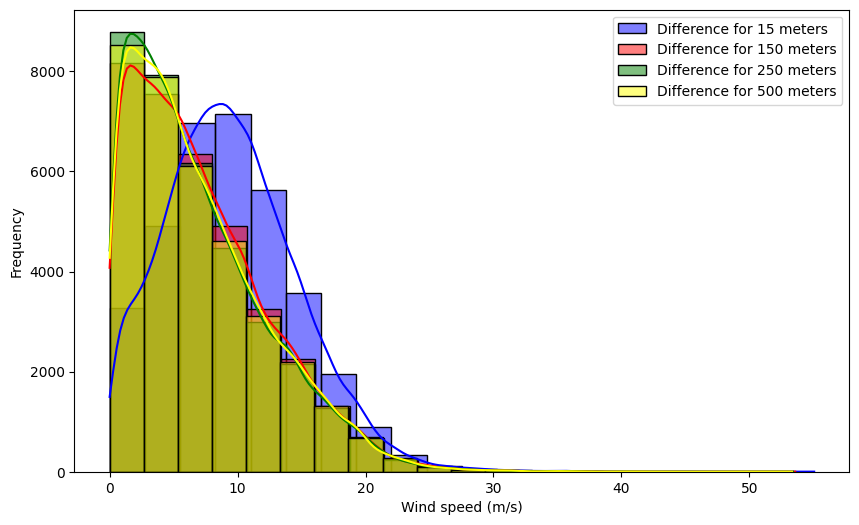

In [18]:
# Plot histograms of wind speed from measurement and reanalysis data
plt.figure(figsize=(10, 6))
diff_15 = abs(data.f - data.ws_15)
diff_150 = abs(data.f - data.ws_150)
diff_250 = abs(data.f - data.ws_250)
diff_500 = abs(data.f - data.ws_500)
sns.histplot(diff_15, bins=20, kde=True, color='blue', label='Difference for 15 meters')
sns.histplot(diff_150, bins=20, kde=True, color='red', label='Difference for 150 meters')
sns.histplot(diff_250, bins=20, kde=True, color='green', label='Difference for 250 meters')
sns.histplot(diff_500, bins=20, kde=True, color='yellow', label='Difference for 500 meters')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig('./data/figures/wind_speed_difference_each_en.png')
plt.show()

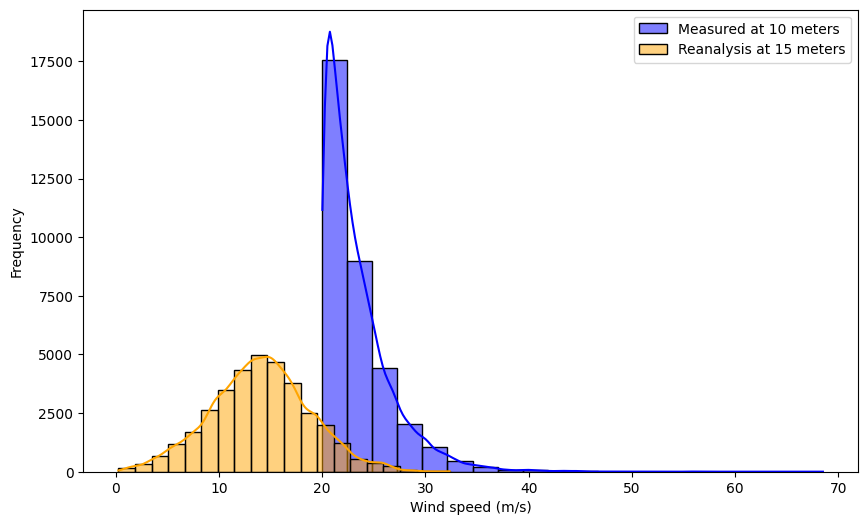

In [19]:
# Plot histograms of wind speed from measurement and reanalysis data
plt.figure(figsize=(10, 6))
sns.histplot(data.f, bins=20, kde=True, color='blue', label='Measured at 10 meters')
sns.histplot(data.ws_15, bins=20, kde=True, color='orange', label='Reanalysis at 15 meters')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig('./data/figures/wind_speed_difference_en.png')
plt.show()

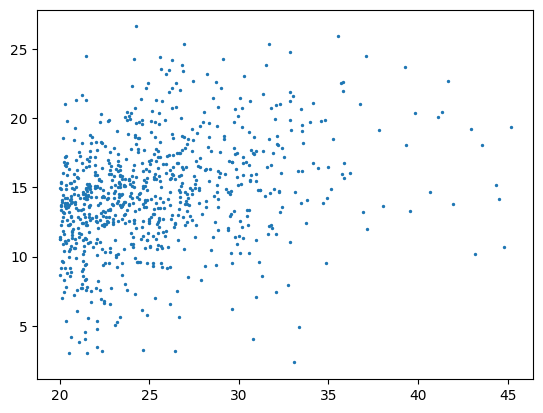

In [20]:
tmp = data[data.stod == 4275]
plt.scatter(tmp.f, tmp.ws_15, s = 2)
plt.show()

In [36]:
tmp.iloc[:20]

,time,stod,f,fg,d,X,Y,ws_15,ws_150,ws_250,...,130,131,132,133,134,135,136,137,138,139
26821,2005-09-13 18:00:00,4275,20.52,23.86,20.8,721568.2334,533229.2891,16.2948,19.1481,19.8991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26822,2005-09-23 09:00:00,4275,20.52,23.80,15.0,721568.2334,533229.2891,10.3852,11.1627,11.2241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26823,2005-09-26 15:00:00,4275,21.30,25.87,79.8,721568.2334,533229.2891,11.2164,12.1531,12.3254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26824,2005-09-28 15:00:00,4275,20.24,23.58,307.9,721568.2334,533229.2891,16.7972,19.4662,20.0711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26825,2005-10-01 00:00:00,4275,30.98,36.06,5.0,721568.2334,533229.2891,17.6400,20.7566,21.6213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26826,2005-10-02 18:00:00,4275,21.60,27.79,253.3,721568.2334,533229.2891,5.5781,7.6557,8.3525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26827,2005-10-29 12:00:00,4275,26.95,35.01,278.9,721568.2334,533229.2891,10.5514,11.8930,10.9015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26828,2005-10-30 21:00:00,4275,20.77,22.87,76.1,721568.2334,533229.2891,14.5169,16.6658,17.0136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26829,2005-11-12 00:00:00,4275,21.65,25.28,358.6,721568.2334,533229.2891,15.2408,17.1991,17.4300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26830,2005-11-13 15:00:00,4275,25.34,30.14,261.5,721568.2334,533229.2891,7.0414,10.7174,12.3411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
x = data.f
y = data.ws_15

skew = np.mean(abs(x-y)/x)
skew

0.4007541284109441

In [12]:
df = pd.read_feather("C:/Users/brynj/Documents/Mastersverkefni/lokaverkefni_vel/data/Measured/Processed/measurements_CARRA_HOURS_2024-05-06.feather")

df

,timi,stod,f,fg,fsdev,d,dsdev
0,2005-02-16 09:00:00,1350,22.42,33.09,3.16,264.1,8.2
1,2005-04-16 15:00:00,1350,20.85,30.05,3.29,135.8,7.4
2,2005-08-07 12:00:00,1350,20.78,29.76,3.34,136.7,7.5
3,2005-12-08 15:00:00,1350,20.45,27.73,2.88,129.6,8.2
4,2006-01-22 00:00:00,1350,21.25,28.09,2.73,239.3,5.7
...,...,...,...,...,...,...,...
2464,2018-12-10 18:00:00,6235,29.23,39.04,2.70,106.3,6.9
2465,2018-12-13 06:00:00,6235,21.64,29.56,3.44,111.3,8.7
2466,2018-12-17 18:00:00,6235,23.09,37.31,4.00,91.6,10.7
2467,2011-02-11 03:00:00,6237,20.09,31.85,4.60,67.5,14.3


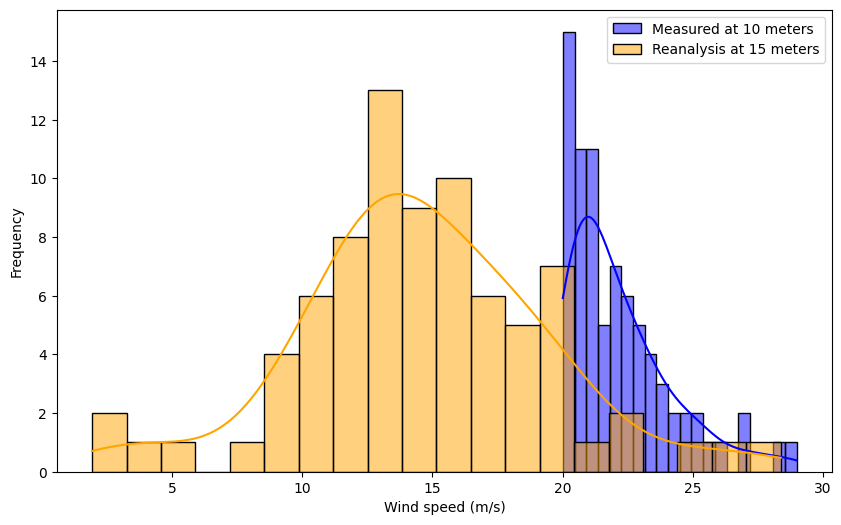

In [22]:
# Plot histograms of wind speed from measurement and reanalysis data
plt.figure(figsize=(10, 6))
sns.histplot(data[data.stod == 1350].f, bins=20, kde=True, color='blue', label='Measured at 10 meters')
sns.histplot(data[data.stod == 1350].ws_15, bins=20, kde=True, color='orange', label='Reanalysis at 15 meters')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig('./data/figures/wind_speed_difference_en.png')
plt.show()

In [34]:
df = pd.read_csv("f_10min_4275.txt")
df[df.f >= 20].iloc[:60]

,timi,stod,f,fg,fsdev,d,dsdev
220,2005-08-24 11:30:00,4275,20.21,23.99,1.76,10.1,3.4
225,2005-08-24 12:20:00,4275,20.01,25.61,1.60,10.5,4.1
228,2005-08-24 12:50:00,4275,20.33,24.69,1.58,7.4,3.8
230,2005-08-24 13:10:00,4275,20.93,24.63,1.53,7.5,3.2
231,2005-08-24 13:20:00,4275,20.42,24.96,1.61,10.1,3.8
232,2005-08-24 13:30:00,4275,20.44,25.20,1.74,6.3,3.4
234,2005-08-24 13:50:00,4275,21.81,26.41,1.73,9.0,3.8
235,2005-08-24 14:00:00,4275,21.39,25.81,1.68,8.5,3.3
236,2005-08-24 14:10:00,4275,21.58,25.76,1.85,8.9,4.5
237,2005-08-24 14:20:00,4275,21.17,24.29,1.26,10.4,3.7


In [19]:
df[df.f >= 20]

,timi,stod,f,fg,fsdev,d,dsdev
63265,2006-11-05 09:40:00,1475,20.27,30.64,3.26,244.4,9.5
120810,2007-12-11 00:50:00,1475,20.78,30.35,3.93,129.1,10.0
121104,2007-12-13 01:50:00,1475,23.99,37.17,4.36,129.3,10.4
121105,2007-12-13 02:00:00,1475,22.93,36.39,4.06,134.9,10.4
121106,2007-12-13 02:10:00,1475,21.68,33.58,4.33,138.5,9.9
121107,2007-12-13 02:20:00,1475,21.13,30.74,3.68,140.2,9.7
121108,2007-12-13 02:30:00,1475,20.57,30.35,3.88,141.9,9.5
121110,2007-12-13 02:50:00,1475,21.19,30.74,3.49,157.0,9.5
121111,2007-12-13 03:00:00,1475,20.63,31.75,4.67,168.4,10.4
121112,2007-12-13 03:10:00,1475,20.05,30.61,3.60,175.8,10.4


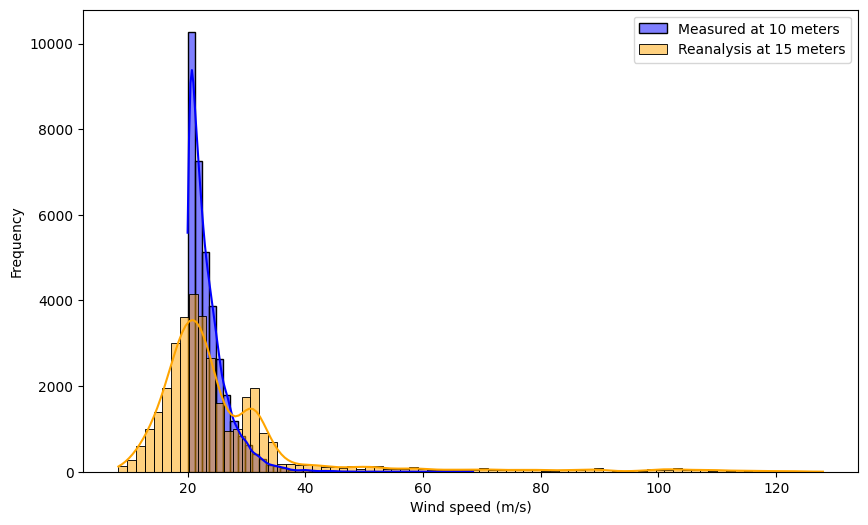

In [20]:
# Plot histograms of wind speed from measurement and reanalysis data
plt.figure(figsize=(10, 6))
sns.histplot(data.f, bins=40, kde=True, color='blue', label='Measured at 10 meters')
sns.histplot(custom_distribution_transform(data.ws_15), bins=80, kde=True, color='orange', label='Reanalysis at 15 meters')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig('./data/figures/transformed_reanalysis_vs_measured_en.png')
plt.show()

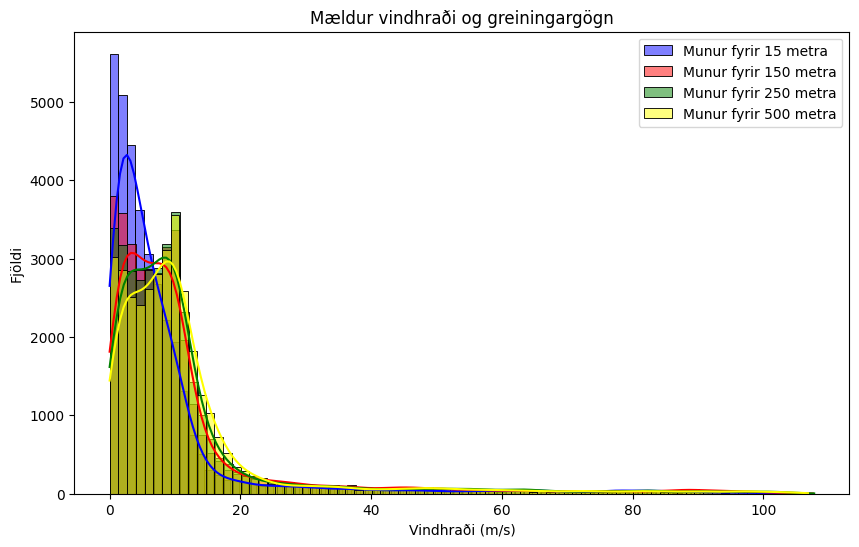

In [21]:
# Plot histograms of wind speed from measurement and reanalysis data
plt.figure(figsize=(10, 6))
diff_15 = abs(data.f - custom_distribution_transform(data.ws_15))
diff_150 = abs(data.f - custom_distribution_transform(data.ws_150))
diff_250 = abs(data.f - custom_distribution_transform(data.ws_250))
diff_500 = abs(data.f - custom_distribution_transform(data.ws_500))
sns.histplot(diff_15, bins=80, kde=True, color='blue', label='Munur fyrir 15 metra')
sns.histplot(diff_150, bins=80, kde=True, color='red', label='Munur fyrir 150 metra')
sns.histplot(diff_250, bins=80, kde=True, color='green', label='Munur fyrir 250 metra')
sns.histplot(diff_500, bins=80, kde=True, color='yellow', label='Munur fyrir 500 metra')
plt.xlabel('Vindhraði (m/s)')
plt.ylabel('Fjöldi')
plt.title('Mældur vindhraði og greiningargögn')
plt.legend()
#plt.savefig('./data/figures/transformed_reanalysis_wind_speed_difference_all_height_levels.png')
plt.show()